In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from mlresearch.utils import set_matplotlib_style
from recgame.environments import ModelRetrainEnvironment
from recgame.data_augmentation import CDA
from functions import (
    fairness_metrics_viz_data, 
    biased_data_generator_hc, 
    get_scaler_hc, 
    fairness_metrics_overall, 
    fairness_metrics_overall_visualizations, 
    fairness_metrics_per_time_step, 
    fairness_metrics_viz_data,
    IgnoreGroupRanker
)
from recourse_aware_andrew import RecourseAwareClassifer

In [2]:
set_matplotlib_style(16)

# Some variables to define the problem
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED+1)
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100
BIAS_FACTOR = 1

# Environment variables
N_LOANS = 10  # np.array([20, 1, 10, 30, 0, 5, 50, 10, 40])
ADAPTATION = .1  # np.array([.2, .1, .3, .25, .1, .4, .05, .05, .2])
NEW_AGENTS = 10  # np.array([40, 10, 50, 5, 0, 100, 0, 0, 20])

# NFeatureRecourse ignoring categorical feature

In [3]:
import warnings
from typing import Union
import numpy as np
from recgame.recourse.base import BaseRecourse


class NFeatureRecourse(BaseRecourse):
    """TODO: Add documentation."""

    def __init__(
        self,
        model,
        n_features: int = None,
        threshold=0.5,
        categorical: Union[list, np.ndarray] = None,
        immutable: Union[list, np.ndarray] = None,
        step_direction: dict = None,
        y_desired: Union[int, str] = 1,
    ):
        super().__init__(
            model=model,
            threshold=threshold,
            categorical=categorical,
            immutable=immutable,
            step_direction=step_direction,
            y_desired=y_desired,
        )

        # if categorical is not None and categorical != []:
        #     raise TypeError(
        #         "NFeatureRecourse does not work with categorical features. Consider "
        #         "using a different recourse method."
        #     )

        self.n_features = n_features

    def _counterfactual(self, agent, action_set):
        agent_original = agent.copy()

        # Do not change if the agent is over the threshold
        if self.model.predict_proba(agent.to_frame().T)[0, -1] >= self.threshold:
            return agent_original

        categorical_vals = agent_original[self.categorical].values
        agent = agent_original.drop(self.categorical).copy()

        intercept, coefficients, model = self._get_coefficients()

        # Get base vector
        base_vector = coefficients.copy().squeeze()
        n_features = (
            base_vector.shape[0] if self.n_features is None else self.n_features
        )

        is_usable = np.array(
            [
                action_set[col].step_direction in [np.sign(coeff), 0]
                and action_set[col].actionable
                for col, coeff in zip(agent.index, base_vector)
            ]
        )
        base_vector[~is_usable] = 0

        # Use features with highest contribution towards the threshold
        rejected_features = np.argsort(np.abs(base_vector))[:-n_features]
        base_vector[rejected_features] = 0

        base_vector = base_vector / np.linalg.norm(base_vector)
        multiplier = (-intercept - np.dot(agent.values, coefficients.T)) / np.dot(
            base_vector, coefficients.T
        )
        counterfactual = agent + multiplier * base_vector
                        
        lb, ub = np.array(action_set.lb), np.array(action_set.ub)
        
        lb = lb[action_set.df.name.values != self.categorical]
        ub = ub[action_set.df.name.values != self.categorical]

        # Check if base_vector adjustments are not generating invalid counterfactuals
        for i in range(agent.shape[0]):
            # Adjust vector according to features' bounds
            lb_valid = counterfactual >= lb
            ub_valid = counterfactual <= ub

            if lb_valid.all() and ub_valid.all():
                break

            if not lb_valid.all():
                # Fix values to its lower bound
                idx = np.where(~lb_valid)[0]
                agent[idx] = lb[idx]
                base_vector[idx] = 0

            if not ub_valid.all():
                # Fix values to its upper bound
                idx = np.where(~ub_valid)[0]
                agent[idx] = ub[idx]
                base_vector[idx] = 0

            if (base_vector == 0).all():
                # All max/min boundaries have been met.
                counterfactual = agent
            else:
                
                # Redefine counterfactual after adjusting the base vector
                base_vector = base_vector / np.linalg.norm(base_vector)
                multiplier = (
                    -intercept - np.dot(agent.values, coefficients.T)
                ) / np.dot(base_vector, coefficients.T)
                counterfactual = agent + multiplier * base_vector

        lb_valid = counterfactual >= lb
        ub_valid = counterfactual <= ub
        if not (lb_valid.all() and ub_valid.all()):
            warnings.warn(
                "Could not generate a counterfactual to reach the desired threshold."
            )

            
        for cat_feat, value in zip(self.categorical, categorical_vals):
            counterfactual[cat_feat] = value


        return counterfactual


# Define functions

In [4]:
def env_biased_data_generator(n_agents):
    return biased_data_generator_hc(n_agents, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng, N_LOANS=N_LOANS, N_AGENTS=N_AGENTS)

In [5]:
from recgame.environments._behavior_functions import ContinuousFlexible


class ContinuousConstantCustom(ContinuousFlexible):
    """Applies continuous adaptation with constant effort."""
    bias_factor_effort_g0 = 0
    bias_factor_effort_g1 = 0
    
    def effort(self, X, global_adaptation):
        """
        Applies constant effort.

        Returns effort rate.
        """
        # Fetch environment variables
        rng = self.environment._rng

        current_effort = (
            self.environment.effort_ if hasattr(self.environment, "effort_") else None
        )

        df_new = (
            self.environment._new_agents
            if hasattr(self.environment, "_new_agents")
            else X
        )

        counts = Counter(df_new["groups"])
        
        x0 = np.abs(rng.normal(0+self.bias_factor_effort_g0, 1, counts[0]))
        x1 = np.abs(rng.normal(0+self.bias_factor_effort_g1, 1, counts[1]))
        
        x = df_new["groups"].copy()
        x.loc[x==0] = x0
        x.loc[x==1] = x1
        x = x.values

        effort_rate = x * global_adaptation / 20
        effort_rate = pd.Series(effort_rate, index=df_new.index)
        effort_rate = pd.concat([current_effort, effort_rate])

        # return pd.Series(effort_rate, index=X.index)
        return effort_rate

    
def behavior_function_generator(bias_factor_effort_g0, bias_factor_effort_g1):
    behav = ContinuousConstantCustom
    behav.bias_factor_effort_g0 = bias_factor_effort_g0
    behav.bias_factor_effort_g1 = bias_factor_effort_g1
    return behav

# CDA experiment

In [6]:
scaler = get_scaler_hc(
    n_agents=10_000, 
    bias_factor=BIAS_FACTOR, 
    random_state=rng,
    N_AGENTS=N_AGENTS, 
    N_LOANS=N_LOANS
)

In [7]:
df = biased_data_generator_hc(
    N_AGENTS, 
    n_continuous=N_CONTINUOUS, 
    bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng, N_LOANS=N_LOANS, N_AGENTS=N_AGENTS
)
categorical = ["groups"]

model = RecourseAwareClassifer(LogisticRegression(random_state=RNG_SEED), l=100, niter=100, group_feature="groups")
y = IgnoreGroupRanker(np.array([[0.5, 0.5]]), ignore_feature=categorical).predict(df)

model.fit(df, y)

/home/joaofonseca/Research/recourse-game/recourse-game/notebooks/recourse_aware_andrew.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/home/joaofonseca/Research/recourse-game/recourse-game/notebooks/recourse_aware_andrew.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


RecourseAwareClassifer(init_model=LogisticRegression(random_state=42),
                       niter=100)

In [8]:
model.w_

array([  3.62470411, -11.89326051,   9.2685564 ])

In [9]:
model.predict_proba(df)

array([[2.76123502e-01, 7.23876498e-01],
       [2.76932950e-01, 7.23067050e-01],
       [3.25542128e-01, 6.74457872e-01],
       [4.91549753e-01, 5.08450247e-01],
       [1.61807072e-01, 8.38192928e-01],
       [9.59790195e-01, 4.02098054e-02],
       [9.94772520e-01, 5.22747959e-03],
       [9.97930627e-01, 2.06937316e-03],
       [9.04519612e-01, 9.54803876e-02],
       [9.98109246e-01, 1.89075405e-03],
       [9.50909932e-01, 4.90900685e-02],
       [8.93630359e-01, 1.06369641e-01],
       [9.72744263e-01, 2.72557367e-02],
       [9.53731708e-01, 4.62682919e-02],
       [9.97184178e-01, 2.81582204e-03],
       [9.96852136e-01, 3.14786445e-03],
       [9.81401912e-01, 1.85980884e-02],
       [9.90530962e-01, 9.46903846e-03],
       [9.81303484e-01, 1.86965162e-02],
       [9.98654821e-01, 1.34517902e-03],
       [9.98912766e-01, 1.08723400e-03],
       [9.84119719e-01, 1.58802811e-02],
       [8.17397940e-01, 1.82602060e-01],
       [9.95422819e-01, 4.57718058e-03],
       [9.676847

# Environment experiment

In [10]:
# Define the necessary components to run simulation
recourse = NFeatureRecourse(model, categorical=["groups"], immutable=["groups"])# , random_state=RNG_SEED)
recourse.set_actions(df)
recourse.action_set_.lb = [-0.1, -0.1, 0]
recourse.action_set_.ub = [1.1, 1.1, 1]

environment = ModelRetrainEnvironment(
    X=df,
    recourse=recourse,
    data_source_func=env_biased_data_generator,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="continuous_constant",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(20)

/home/joaofonseca/Research/recourse-game/recourse-game/notebooks/recourse_aware_andrew.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/home/joaofonseca/Research/recourse-game/recourse-game/notebooks/recourse_aware_andrew.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/home/joaofonseca/Research/recourse-game/recourse-game/notebooks/recourse_aware_andrew.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/home/joaofonseca/Research/recourse-game/recourse-game/notebooks/recourse_aware_andrew.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/home/joaofonseca/Research/recourse-game/recourse-game/notebooks/recourse_aware_andrew.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/home/joaofonseca/Research/recourse-game/recourse-game/notebooks/recourse_aware_andrew.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/home/joaofonsec

ModelRetrainEnvironment(X=          f0        f1  groups
0   0.753099  0.471306     1.0
1   0.850924  0.597270     1.0
2   0.736156  0.474958     1.0
3   0.748188  0.565340     1.0
4   0.839155  0.508249     1.0
..       ...       ...     ...
95  0.163038  0.385779     0.0
96  0.311944  0.644092     0.0
97  0.181467  0.755729     0.0
98  0.151421  0.414310     0.0
99  0.366930  0.080369     0.0

[100 rows x 3 columns],
                        adaptation=0.1, behavior_function='continuous_constant',
                        data_source_func=<function env_biased_data_generator at 0x7f6f56259480>,
                        growth_rate=10, growth_rate_type='absolute',
                        random_state=42,
                        recourse=NFeatureRecourse(categorical=['groups'],
                                                  immutable=['groups'],
                                                  model=RecourseAwareClassifer(init_model=LogisticRegression(random_state=42),
                                                                               niter=100),
                                                  threshold=0.30798887868119296),
                        threshold=10)

In [11]:
environment.X_, environment.outcome_

from collections import Counter
Counter(environment.outcome_)

Counter({0: 90, 1: 10})

<Axes: title={'center': 'Population scores over 21 time steps'}, xlabel='Step', ylabel='Score'>

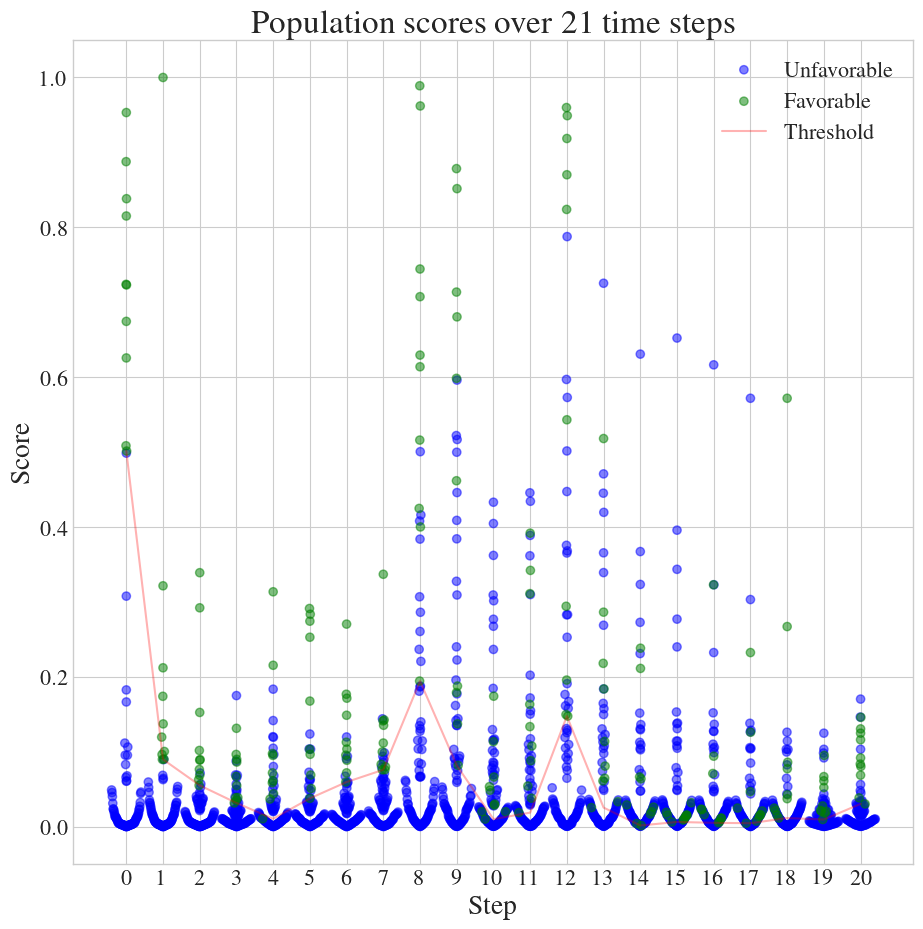

In [12]:
environment.plot.agent_scores(ref_model_step=0)

<Axes: title={'center': 'Population at t=2'}, xlabel='Component 1', ylabel='Component 2'>

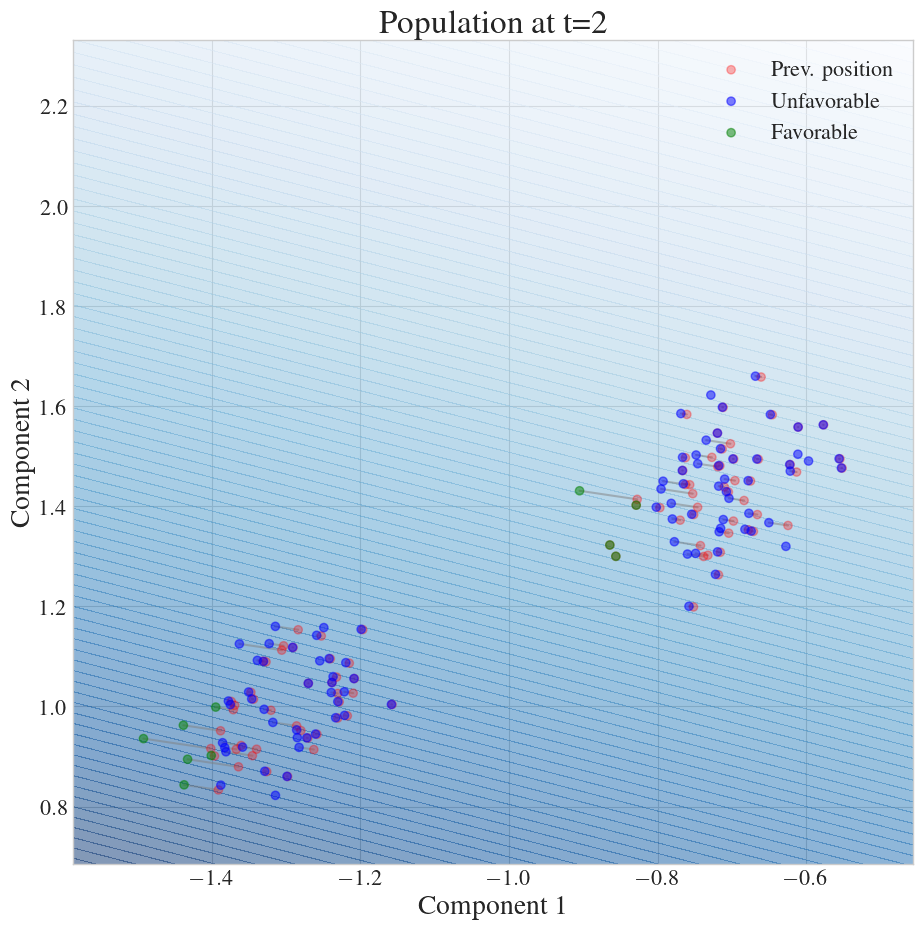

In [13]:
environment.plot.scatter(2)

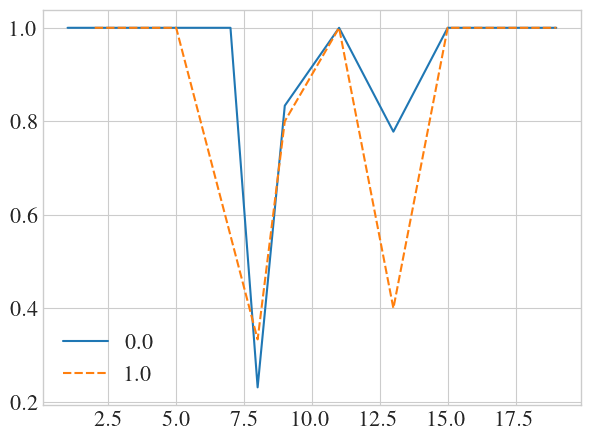

In [14]:
fairness_metrics_per_time_step(environment)

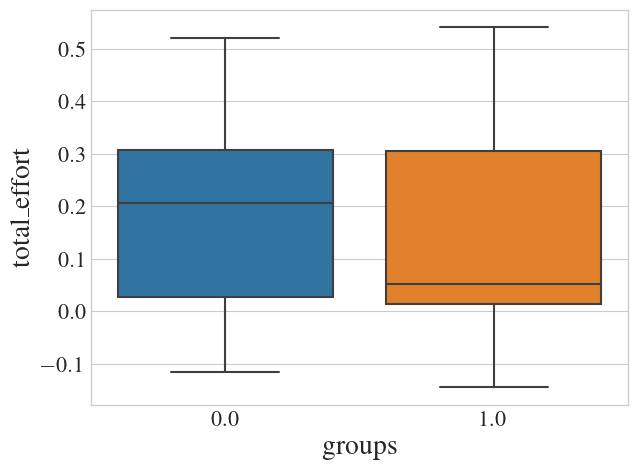

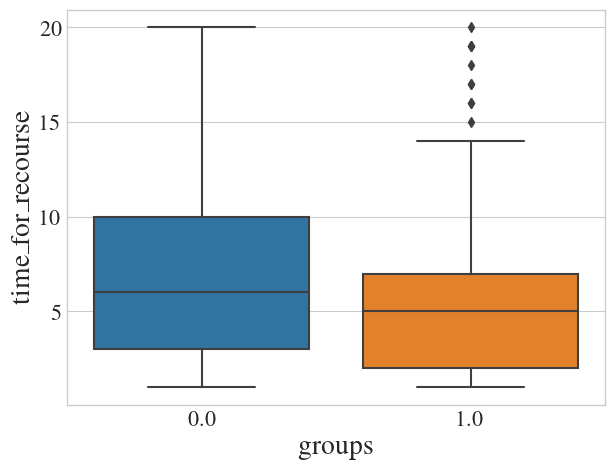

{'etr_disparity': 1.2020524772587555, 'disparate_ttr': 1.1182450508293211}

In [15]:
fairness_metrics_overall_visualizations(environment)
# Boxplots for different qualification values

In [16]:
fairness_metrics_viz_data(environment)

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures,groups,time_for_recourse,total_effort
5,0,2,2.0,0.040210,0.472012,0,1.0,2.0,0.431803
6,0,5,8.0,0.005227,0.281957,0,1.0,8.0,0.276729
7,0,9,14.0,0.002069,0.308049,1,1.0,14.0,0.305979
8,0,1,1.0,0.095480,0.100438,0,1.0,1.0,0.004957
9,0,12,17.0,0.001891,0.356415,0,1.0,17.0,0.354525
...,...,...,...,...,...,...,...,...,...
245,15,1,17.0,0.475851,0.359928,0,0.0,2.0,-0.115923
252,16,1,18.0,0.318273,0.324079,0,1.0,2.0,0.005806
254,16,1,17.0,0.315927,0.356918,0,1.0,1.0,0.040992
257,16,2,20.0,0.308852,0.312451,0,0.0,4.0,0.003600


# Analysis

In [17]:
steps_info = environment.analysis.steps_info()
steps_info

/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2259: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2259: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2259: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2259: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2259: Runt

,n_adapted,n_candidates,favorable_outcomes,success_rate,threshold,threshold_drift,new_agents,new_agents_proba,moving_agent_proba,success_proba
1,90.0,1.0,10.0,1.000000,0.495607,-0.011557,10.0,0.11,0.000000e+00,NaN
2,90.0,8.0,10.0,1.000000,0.314866,-0.364685,10.0,0.11,2.283535e-02,0.956418
3,26.0,0.0,10.0,NaN,0.343053,0.089520,10.0,0.11,1.858744e-10,1.000000
4,90.0,3.0,10.0,1.000000,0.342465,-0.001714,10.0,0.11,3.995553e-02,0.999188
5,90.0,4.0,10.0,1.000000,0.289342,-0.155120,10.0,0.12,1.655990e-01,1.000000
6,6.0,0.0,10.0,NaN,0.275267,-0.048646,10.0,0.12,1.524451e-01,0.951295
7,39.0,1.0,10.0,1.000000,0.277489,0.008075,10.0,0.12,1.000958e-01,0.373546
8,90.0,31.0,10.0,0.290323,0.314517,0.133436,10.0,0.11,4.021113e-14,1.000000
9,90.0,11.0,10.0,0.818182,0.292447,-0.070170,10.0,0.12,9.292008e-02,0.985475
10,15.0,0.0,10.0,NaN,0.458716,0.568544,10.0,0.11,1.122966e-211,1.000000


In [18]:
(1 - steps_info["success_rate"]) * steps_info["n_candidates"], ((1 - steps_info["success_rate"]) * steps_info["n_candidates"]).sum()

(1      0.0
 2      0.0
 3      NaN
 4      0.0
 5      0.0
 6      NaN
 7      0.0
 8     22.0
 9      2.0
 10     NaN
 11     0.0
 12     NaN
 13     5.0
 14     NaN
 15     0.0
 16     NaN
 17     0.0
 18     NaN
 19     0.0
 20     NaN
 dtype: float64,
 29.0)

In [19]:
from collections import Counter
Counter(environment.analysis.agents_info().n_failures), environment.analysis.agents_info().n_failures.sum()


(Counter({0: 273, 1: 25, 2: 2}), 29)

In [20]:
environment.analysis.agents_info()

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures
0,0,0,0.0,0.723876,0.723876,0
1,0,0,0.0,0.723067,0.723067,0
2,0,0,0.0,0.674458,0.674458,0
3,0,0,0.0,0.508450,0.508450,0
4,0,0,0.0,0.838193,0.838193,0
...,...,...,...,...,...,...
295,20,0,NaN,0.299206,NaN,0
296,20,0,NaN,0.288177,NaN,0
297,20,0,NaN,0.289243,NaN,0
298,20,0,20.0,0.311336,0.311336,0


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
sns.__version__

'0.12.2'

In [22]:
clf = environment.metadata_[1]["model"]
clf.coef_, clf.intercept_

(array([[-1.11776712,  2.42578911]]), array([-0.30802199]))

[[0.5 0.5]] -0.56


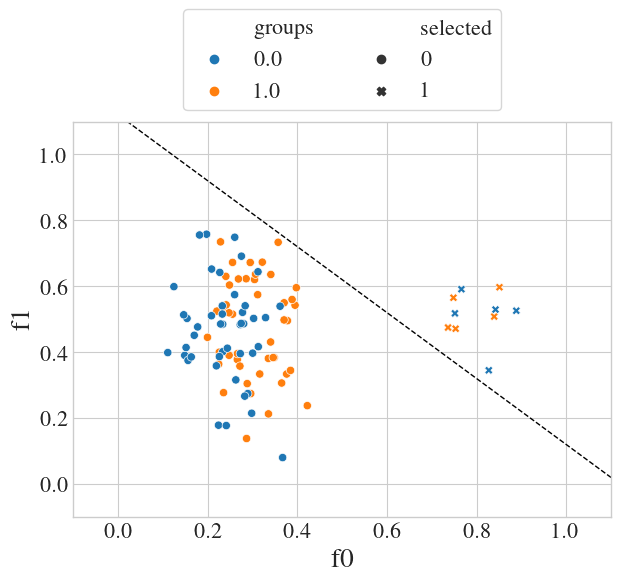

In [23]:
clf = IgnoreGroupRanker(np.array([[0.5, 0.5]]), threshold=0.56, ignore_feature=["groups"], intercept=-0.56)
df = environment.metadata_[0]["X"].copy()
df["selected"] = clf.predict(df)
print(clf.coef_, clf.intercept_)

# Retrieve the model parameters
b = clf.intercept_
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary
xmin, xmax = -.1, 1.1
ymin, ymax = -.1, 1.1
xd = np.array([xmin, xmax])
yd = m*xd + c
ax = sns.scatterplot(data=df, x="f0",y="f1",hue="groups" ,style="selected")
ax.set(ylim=(ymin, ymax), xlim=(xmin, xmax))
plt.plot(xd, yd, 'k', lw=1, ls='--')
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=2, title=None, frameon=True,
)

[[-11.89326051   9.2685564 ]] [3.62470411]


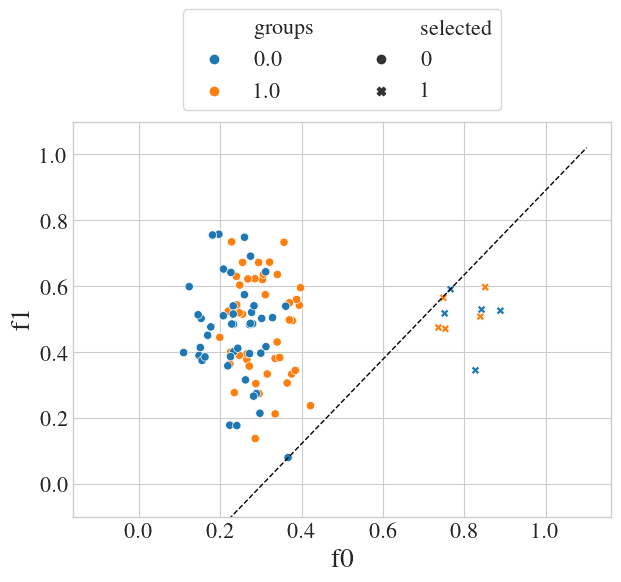

In [24]:
time_step = 0
clf = deepcopy(environment.metadata_[time_step]["model"])
# clf.intercept_ = np.array([[0.22]])
print(clf.coef_, clf.intercept_)
df = environment.metadata_[time_step]["X"].copy()
df["selected"] = environment.metadata_[time_step]["outcome"]

# Retrieve the model parameters
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary
xmin, xmax = -.1, 1.1
ymin, ymax = -.1, 1.1
xd = np.array([xmin, xmax])
yd = m*xd + c
ax = sns.scatterplot(data=df, x="f0",y="f1",hue="groups" ,style="selected")
ax.set(ylim=(ymin, ymax))
plt.plot(xd, yd, 'k', lw=1, ls='--')
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=2, title=None, frameon=True,
)

[[-1.11776712  2.42578911]] [[-0.4]]


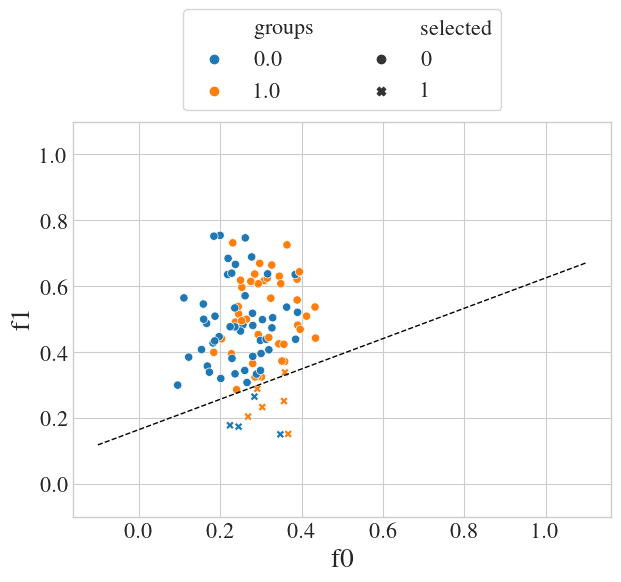

In [25]:
time_step = 2
clf = deepcopy(environment.metadata_[time_step-1]["model"])
clf.intercept_ = np.array([[-.4]])
print(clf.coef_, clf.intercept_)
df = environment.metadata_[time_step]["X"].copy()
df["selected"] = environment.metadata_[time_step]["outcome"]

# Retrieve the model parameters
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary
xmin, xmax = -.1, 1.1
ymin, ymax = -.1, 1.1
xd = np.array([xmin, xmax])
yd = m*xd + c
ax = sns.scatterplot(data=df, x="f0",y="f1",hue="groups" ,style="selected")
ax.set(ylim=(ymin, ymax))
plt.plot(xd, yd, 'k', lw=1, ls='--')
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=2, title=None, frameon=True,
)

[[0.47645914 0.76993979]] [[-0.309]]


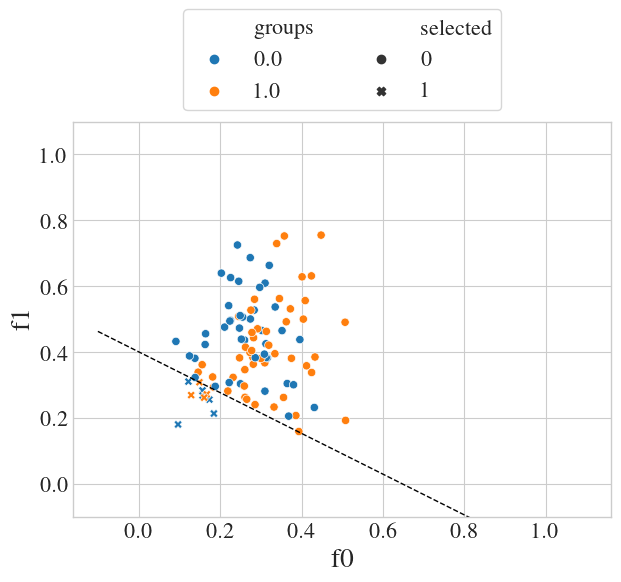

In [35]:
time_step = 15
clf = deepcopy(environment.metadata_[time_step-1]["model"])
clf.intercept_ = np.array([[-0.309]])
print(clf.coef_, clf.intercept_)
df = environment.metadata_[time_step]["X"].copy()
df["selected"] = environment.metadata_[time_step]["outcome"]

# Retrieve the model parameters
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary
xmin, xmax = -.1, 1.1
ymin, ymax = -.1, 1.1
xd = np.array([xmin, xmax])
yd = m*xd + c
ax = sns.scatterplot(data=df, x="f0",y="f1",hue="groups" ,style="selected")
ax.set(ylim=(ymin, ymax))
plt.plot(xd, yd, 'k', lw=1, ls='--')
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=2, title=None, frameon=True,
)